In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import mutual_info_classif


Label Encoding.

In [4]:

class SafeLabelEncoder:
    def __init__(self):
        self.encoders = {}
        self.known_labels = {}
    
    def fit(self, data, columns):
        """Fit label encoders for specified columns"""
        for col in columns:
            self.encoders[col] = LabelEncoder()
            unique_labels = np.unique(data[col].astype(str))
            self.known_labels[col] = set(unique_labels)
            self.encoders[col].fit(unique_labels)
    
    def transform(self, data, columns):
        """Transform labels to encoded values"""
        df = data.copy()
        for col in columns:
            unique_labels = set(df[col].astype(str))
            unknown_labels = unique_labels - self.known_labels[col]
            
            if unknown_labels:
                print(f"Warning: Unknown labels found in {col}: {unknown_labels}")
                most_common = max(set(data[col]), key=list(data[col]).count)
                for label in unknown_labels:
                    df.loc[df[col] == label, col] = most_common
            
            df[col] = self.encoders[col].transform(df[col].astype(str))
        return df

class AdvancedFeatureEngineer:
    def __init__(self):
        self.label_encoder = SafeLabelEncoder()
        self.scaler = StandardScaler()
        self.poly = PolynomialFeatures(degree=3, include_bias=False)
        
    def create_features(self, df, is_train=True):
        df_new = df.copy()
        
        # Categorical encoding
        cat_cols = ['Geography', 'Gender', 'Surname']
        if is_train:
            self.label_encoder.fit(df_new, cat_cols)
        df_new = self.label_encoder.transform(df_new, cat_cols)
        
        # 1. Basic ratios and financial indicators
        df_new['Balance_per_Product'] = df_new['Balance'] / (df_new['NumOfProducts'] + 1)
        df_new['Balance_per_Salary'] = df_new['Balance'] / (df_new['EstimatedSalary'] + 1)
        df_new['Credit_to_Salary_Ratio'] = df_new['CreditScore'] / (df_new['EstimatedSalary'] + 1)
        df_new['Balance_to_Credit_Ratio'] = df_new['Balance'] / (df_new['CreditScore'] + 1)
        df_new['Products_per_Tenure'] = df_new['NumOfProducts'] / (df_new['Tenure'] + 1)
        
        # 2. Customer metrics
        df_new['Balance_per_Age'] = df_new['Balance'] / (df_new['Age'] + 1)
        df_new['Salary_per_Age'] = df_new['EstimatedSalary'] / (df_new['Age'] + 1)
        df_new['Credit_per_Age'] = df_new['CreditScore'] / df_new['Age']
        
        # 3. Risk indicators
        df_new['High_Credit_Risk'] = (df_new['CreditScore'] < 600).astype(int)
        df_new['Is_Young_Customer'] = (df_new['Age'] < 30).astype(int)
        df_new['Is_Senior_Customer'] = (df_new['Age'] > 60).astype(int)
        df_new['Has_High_Balance'] = (df_new['Balance'] > df_new['Balance'].mean()).astype(int)
        df_new['Is_Long_Tenure'] = (df_new['Tenure'] > df_new['Tenure'].mean()).astype(int)
        
        # 4. Complex interactions
        df_new['Age_Credit_Interaction'] = df_new['Age'] * np.log1p(df_new['CreditScore'])
        df_new['Tenure_Balance_Interaction'] = df_new['Tenure'] * np.log1p(df_new['Balance'])
        df_new['Product_Credit_Interaction'] = df_new['NumOfProducts'] * df_new['CreditScore']
        df_new['Activity_Score'] = df_new['IsActiveMember'] * (df_new['NumOfProducts'] * df_new['Balance_per_Salary'])
        
        # 5. Geographic and demographic interactions
        df_new['Geo_Age'] = df_new['Geography'] * df_new['Age']
        df_new['Geo_Credit'] = df_new['Geography'] * df_new['CreditScore']
        df_new['Gender_Age'] = df_new['Gender'] * df_new['Age']
        
        # 6. Advanced binning
        df_new['AgeBin'] = pd.qcut(df_new['Age'], q=10, duplicates='drop', labels=False)
        df_new['CreditScoreBin'] = pd.qcut(df_new['CreditScore'], q=10, duplicates='drop', labels=False)
        df_new['BalanceBin'] = pd.qcut(df_new['Balance'].rank(method='first'), q=10, labels=False)
        df_new['SalaryBin'] = pd.qcut(df_new['EstimatedSalary'].rank(method='first'), q=10, labels=False)
        
        # 7. Polynomial features for key metrics
        important_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
        if is_train:
            poly_features = self.poly.fit_transform(df_new[important_features])
        else:
            poly_features = self.poly.transform(df_new[important_features])
        
        poly_columns = [f'poly_{i}' for i in range(poly_features.shape[1])]
        df_new = pd.concat([df_new, pd.DataFrame(poly_features, columns=poly_columns)], axis=1)
        
        # 8. Standardization
        num_cols = df_new.select_dtypes(include=['float64', 'int64']).columns
        if is_train:
            df_new[num_cols] = self.scaler.fit_transform(df_new[num_cols])
        else:
            df_new[num_cols] = self.scaler.transform(df_new[num_cols])
        
        return df_new

class OptimizedModelTrainer:
    def __init__(self):
        self.lr_model = LogisticRegression(
            C=0.01,
            max_iter=2000,
            class_weight='balanced',
            random_state=42,
            solver='liblinear'
        )
        
        self.ridge_model = RidgeClassifier(
            alpha=0.5,
            class_weight='balanced',
            random_state=42
        )
    
    def train_with_kfold(self, X, y, n_splits=5):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        lr_predictions = np.zeros(len(X))
        ridge_predictions = np.zeros(len(X))
        
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Train models
            self.lr_model.fit(X_train, y_train)
            self.ridge_model.fit(X_train, y_train)
            
            # Make predictions
            lr_predictions[val_idx] = self.lr_model.predict_proba(X_val)[:, 1]
            ridge_pred = self.ridge_model.decision_function(X_val)
            ridge_predictions[val_idx] = 1 / (1 + np.exp(-ridge_pred))
        
        return lr_predictions, ridge_predictions
    
    def predict(self, X_test):
        lr_pred = self.lr_model.predict_proba(X_test)[:, 1]
        ridge_pred = self.ridge_model.decision_function(X_test)
        ridge_pred = 1 / (1 + np.exp(-ridge_pred))
        return 0.6 * lr_pred + 0.4 * ridge_pred

def plot_roc_curves(y_true, lr_pred, ridge_pred, ensemble_pred):
    plt.figure(figsize=(10, 8))
    
    # Plot for LogisticRegression
    fpr_lr, tpr_lr, _ = roc_curve(y_true, lr_pred)
    auc_lr = roc_auc_score(y_true, lr_pred)
    plt.plot(fpr_lr, tpr_lr, label=f'LogisticRegression (AUC = {auc_lr:.3f})', color='blue')
    
    # Plot for RidgeClassifier
    fpr_ridge, tpr_ridge, _ = roc_curve(y_true, ridge_pred)
    auc_ridge = roc_auc_score(y_true, ridge_pred)
    plt.plot(fpr_ridge, tpr_ridge, label=f'RidgeClassifier (AUC = {auc_ridge:.3f})', color='green')
    
    # Plot for Ensemble
    fpr_ens, tpr_ens, _ = roc_curve(y_true, ensemble_pred)
    auc_ens = roc_auc_score(y_true, ensemble_pred)
    plt.plot(fpr_ens, tpr_ens, label=f'Ensemble (AUC = {auc_ens:.3f})', color='red', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curves_comparison.png')
    plt.close()

def plot_feature_importance(model, feature_names, title='Feature Importance'):
    importance = np.abs(model.coef_[0])
    feat_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feat_importance = feat_importance.sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_importance)
    plt.title(title)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()

def main():
    print("Loading data...")
    train = pd.read_csv('train.csv')
    test = pd.read_csv('test.csv')
    
    # Prepare data
    y = train['Exited']
    X = train.drop(['Exited', 'id', 'CustomerId'], axis=1)
    X_test = test.drop(['id', 'CustomerId'], axis=1)
    
    # Feature engineering
    print("Performing advanced feature engineering...")
    engineer = AdvancedFeatureEngineer()
    X_processed = engineer.create_features(X, is_train=True)
    X_test_processed = engineer.create_features(X_test, is_train=False)
    
    # Model training and prediction
    print("Training models with K-fold validation...")
    trainer = OptimizedModelTrainer()
    lr_pred, ridge_pred = trainer.train_with_kfold(X_processed, y)
    
    # Ensemble predictions
    train_pred = 0.6 * lr_pred + 0.4 * ridge_pred
    print(f"\nTrain ROC-AUC scores:")
    print(f"LogisticRegression: {roc_auc_score(y, lr_pred):.4f}")
    print(f"RidgeClassifier: {roc_auc_score(y, ridge_pred):.4f}")
    print(f"Ensemble: {roc_auc_score(y, train_pred):.4f}")
    
    # Plot ROC curves
    print("Plotting ROC curves...")
    plot_roc_curves(y, lr_pred, ridge_pred, train_pred)
    
    # Plot feature importance
    print("Plotting feature importance...")
    plot_feature_importance(trainer.lr_model, X_processed.columns, 'Logistic Regression Feature Importance')
    
    # Final test predictions
    print("Making test predictions...")
    test_pred = trainer.predict(X_test_processed)
    
    # Save submission
    submission = pd.DataFrame({
        'id': test['id'],
        'Exited': test_pred
    })
    submission.to_csv('submission_optimized.csv', index=False)
    print("\nSubmission saved. Check visualization files:")
    print("- roc_curves_comparison.png")
    print("- feature_importance.png")

if __name__ == "__main__":
    main()

Loading data...
Performing advanced feature engineering...
Training models with K-fold validation...

Train ROC-AUC scores:
LogisticRegression: 0.8267
RidgeClassifier: 0.8281
Ensemble: 0.8273
Plotting ROC curves...
Plotting feature importance...
Making test predictions...

Submission saved. Check visualization files:
- roc_curves_comparison.png
- feature_importance.png


In [5]:
df = pd.read_csv('train.csv')

df.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)
print(df.isnull().sum())


CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


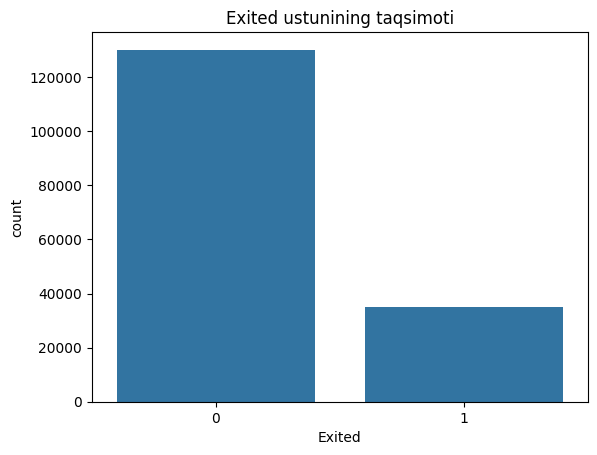

In [6]:
#chizma
sns.countplot(x='Exited', data=df)
plt.title('Exited ustunining taqsimoti')
plt.show()


In [7]:
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

df = pd.get_dummies(df, columns=['Geography'], drop_first=True)


#pearson
for col in numerical_cols:
    corr, p_value = stats.pearsonr(df[col], df['Exited'])
    print(f'Pearson korrelyatsiyasi ({col} va Exited): {corr:.4f}, p-qiymat: {p_value:.4f}')


Pearson korrelyatsiyasi (CreditScore va Exited): -0.0274, p-qiymat: 0.0000
Pearson korrelyatsiyasi (Age va Exited): 0.3408, p-qiymat: 0.0000
Pearson korrelyatsiyasi (Tenure va Exited): -0.0196, p-qiymat: 0.0000
Pearson korrelyatsiyasi (Balance va Exited): 0.1297, p-qiymat: 0.0000
Pearson korrelyatsiyasi (NumOfProducts va Exited): -0.2146, p-qiymat: 0.0000
Pearson korrelyatsiyasi (EstimatedSalary va Exited): 0.0188, p-qiymat: 0.0000


In [8]:
#spearman
for col in numerical_cols:
    corr, p_value = stats.spearmanr(df[col], df['Exited'])
    print(f'Spearman korrelyatsiyasi ({col} va Exited): {corr:.4f}, p-qiymat: {p_value:.4f}')


Spearman korrelyatsiyasi (CreditScore va Exited): -0.0291, p-qiymat: 0.0000
Spearman korrelyatsiyasi (Age va Exited): 0.3547, p-qiymat: 0.0000
Spearman korrelyatsiyasi (Tenure va Exited): -0.0194, p-qiymat: 0.0000
Spearman korrelyatsiyasi (Balance va Exited): 0.1264, p-qiymat: 0.0000
Spearman korrelyatsiyasi (NumOfProducts va Exited): -0.2668, p-qiymat: 0.0000
Spearman korrelyatsiyasi (EstimatedSalary va Exited): 0.0200, p-qiymat: 0.0000


In [9]:

for col in numerical_cols:
    corr, p_value = stats.kendalltau(df[col], df['Exited'])
    print(f'Kendall\'s Tau korrelyatsiyasi ({col} va Exited): {corr:.4f}, p-qiymat: {p_value:.4f}')


Kendall's Tau korrelyatsiyasi (CreditScore va Exited): -0.0238, p-qiymat: 0.0000
Kendall's Tau korrelyatsiyasi (Age va Exited): 0.2948, p-qiymat: 0.0000
Kendall's Tau korrelyatsiyasi (Tenure va Exited): -0.0166, p-qiymat: 0.0000
Kendall's Tau korrelyatsiyasi (Balance va Exited): 0.1127, p-qiymat: 0.0000
Kendall's Tau korrelyatsiyasi (NumOfProducts va Exited): -0.2642, p-qiymat: 0.0000
Kendall's Tau korrelyatsiyasi (EstimatedSalary va Exited): 0.0163, p-qiymat: 0.0000


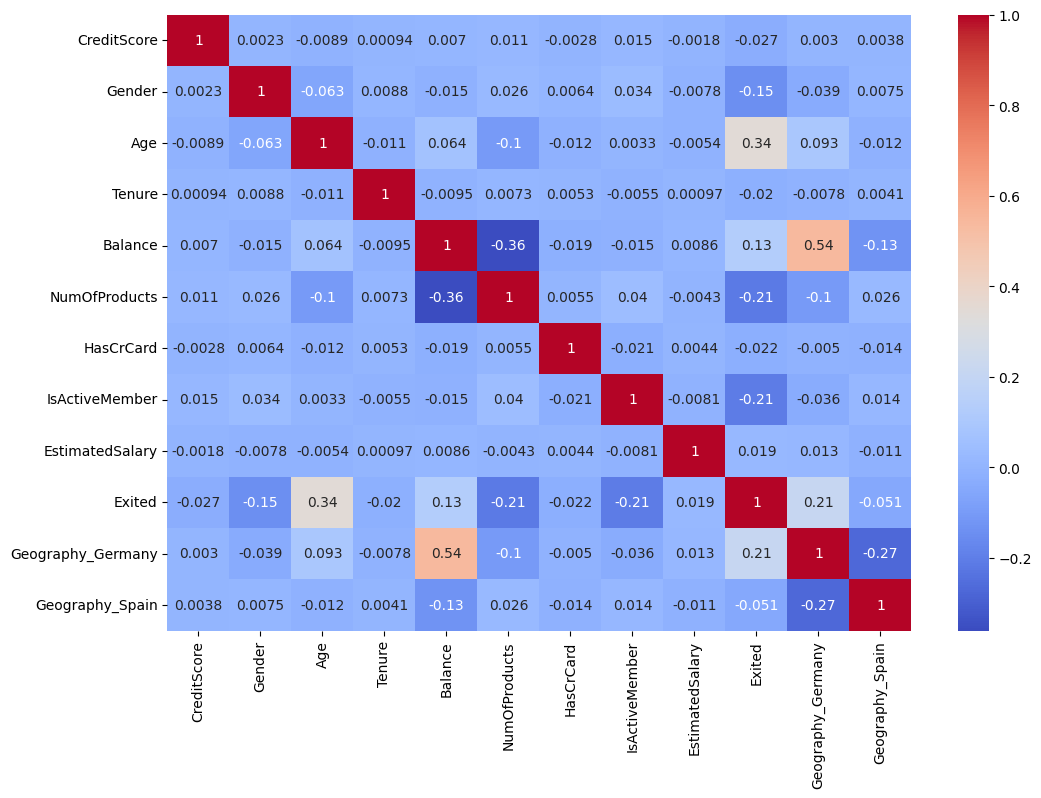

In [10]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [11]:
#phik
import phik

phik_matrix = df.phik_matrix()

phik_target = phik_matrix['Exited'].sort_values(ascending=False)
print(phik_target)


interval columns not set, guessing: ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Exited               1.000000
NumOfProducts        0.607392
Age                  0.521917
Geography_Germany    0.325437
IsActiveMember       0.324228
Gender               0.227953
Balance              0.189029
Geography_Spain      0.080181
Tenure               0.049479
CreditScore          0.048688
HasCrCard            0.034529
EstimatedSalary      0.034060
Name: Exited, dtype: float64


In [12]:
# mutual_info

X = df.drop('Exited', axis=1)
y = df['Exited']

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)
mi_scores.sort_values(ascending=False, inplace=True)

print(mi_scores)


NumOfProducts        0.099203
Age                  0.084642
IsActiveMember       0.045580
Gender               0.033150
HasCrCard            0.024046
Geography_Germany    0.021474
Balance              0.014261
EstimatedSalary      0.008816
Geography_Spain      0.003789
CreditScore          0.003348
Tenure               0.001935
dtype: float64


In [13]:
def woe_iv(data, feature, target):
    
    lst = []
    unique_values = data[feature].unique()
    for val in unique_values:
        total = len(data[data[feature] == val])
        event = len(data[(data[feature] == val) & (data[target] == 1)])
        non_event = len(data[(data[feature] == val) & (data[target] == 0)])
        dist_event = event / data[target].sum()
        dist_non_event = non_event / (len(data[target]) - data[target].sum())
        woe = np.log(dist_event / dist_non_event) if dist_non_event != 0 and dist_event != 0 else 0
        iv = (dist_event - dist_non_event) * woe
        lst.append({'Value': val, 'WOE': woe, 'IV': iv})
    df_woe_iv = pd.DataFrame(lst)
    iv = df_woe_iv['IV'].sum()
    return df_woe_iv, iv

iv_values = {}
for col in X.columns:
    df_woe_iv, iv = woe_iv(df, col, 'Exited')
    iv_values[col] = iv
    print(f"Feature: {col}")
    print(df_woe_iv)
    print(f"IV: {iv}\n")
    

Feature: CreditScore
     Value       WOE        IV
0      668  0.172017  0.000097
1      627  0.035045  0.000009
2      678 -0.022215  0.000007
3      581 -0.022606  0.000003
4      716 -0.150296  0.000074
..     ...       ...       ...
452    358  0.000000  0.000000
453    448  0.000000 -0.000000
454    423  0.000000  0.000000
455    382  0.000000 -0.000000
456    373  0.000000  0.000000

[457 rows x 3 columns]
IV: 0.054625793097281855

Feature: Gender
   Value       WOE        IV
0      1 -0.349959  0.062214
1      0  0.369299  0.065652
IV: 0.1278653503047812

Feature: Age
    Value       WOE        IV
0   33.00 -0.886833  0.030196
1   40.00  0.023127  0.000026
2   34.00 -1.287063  0.057502
3   36.00 -0.742612  0.022696
4   30.00 -1.144477  0.029468
..    ...       ...       ...
66  83.00  0.622168  0.000008
67  36.44  0.000000 -0.000000
68  85.00  0.000000 -0.000000
69  32.34  0.000000 -0.000000
70  84.00  0.000000 -0.000000

[71 rows x 3 columns]
IV: 1.0093834329572555

Feature: T

In [14]:
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'MI': mi_scores.values,
    'IV': [iv_values[col] for col in X.columns],
    'PhiK': phik_target.drop('Exited').values
})

feature_scores.sort_values(by=['MI', 'IV', 'PhiK'], ascending=False)
print(feature_scores)

        

              Feature        MI        IV      PhiK
0         CreditScore  0.099203  0.054626  0.607392
1              Gender  0.084642  0.127865  0.521917
2                 Age  0.045580  1.009383  0.325437
3              Tenure  0.033150  0.009601  0.324228
4             Balance  0.024046  0.308564  0.227953
5       NumOfProducts  0.021474  1.194070  0.189029
6           HasCrCard  0.014261  0.002888  0.080181
7      IsActiveMember  0.008816  0.278349  0.049479
8     EstimatedSalary  0.003789  0.349324  0.048688
9   Geography_Germany  0.003348  0.233836  0.034529
10    Geography_Spain  0.001935  0.016602  0.034060
